# 시계열 분석

> 1. 연도별 계절별 월별 일별 시 분 초별로 시간의 흐름에 따라 관측된 자료
> 2. 시계열 자료의 여러 형태
     * 시계열 그림 시간의 경과에 따라 시계열자료의 값이 변하는 것을 그린 그림
> 3. 목적
      - 1) 미래 예측
      - 2) 시스템 또는 확률과정의 이해와 제어

# 1. Numpy의 profit으로 회귀(regression) 분석하기
 * 1) 야후 파이낸스 데이터를 가져오기 위한 yfinance
        * pip install yfinance
 *  2) 예측 모델링 및 시각화를 위한 prophet
        * pip install prophet
 *  3) Prophets는 Plotly 기반으로 데이터를 시각화하므로
        * pip install plotly

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False   # - 기호 깨지는 것 방지
# f_path = "/Library/Fonts/AppleGothic.ttf"   -> MAC
f_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

* 홈페이지 방문객 숫자(날짜, 방문객 수)

In [3]:
pweb = pd.read_csv('../../data/08. PinkWink Web Traffic.csv',
                  encoding='utf-8', thousands=',',
                  names=['date', 'hit'], index_col=0)
pweb = pweb[pweb['hit'].notnull()]
pweb.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


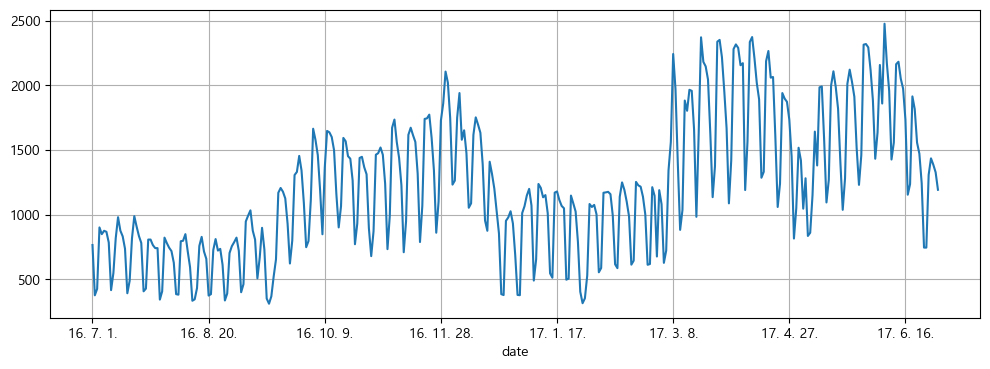

In [4]:
pweb['hit'].plot(figsize=(12,4), grid=True);

In [5]:
time = np.arange(0,len(pweb)) # 시간(time) 축 생성 (0~364)
# print(time)
traffic = pweb['hit'].values # 웹 트래픽 traffic 변수에 저장
fx = np.linspace(0, time[-1], 1000)
print(fx)

[  0.           0.36436436   0.72872873   1.09309309   1.45745746
   1.82182182   2.18618619   2.55055055   2.91491491   3.27927928
   3.64364364   4.00800801   4.37237237   4.73673674   5.1011011
   5.46546547   5.82982983   6.19419419   6.55855856   6.92292292
   7.28728729   7.65165165   8.01601602   8.38038038   8.74474474
   9.10910911   9.47347347   9.83783784  10.2022022   10.56656657
  10.93093093  11.2952953   11.65965966  12.02402402  12.38838839
  12.75275275  13.11711712  13.48148148  13.84584585  14.21021021
  14.57457457  14.93893894  15.3033033   15.66766767  16.03203203
  16.3963964   16.76076076  17.12512513  17.48948949  17.85385385
  18.21821822  18.58258258  18.94694695  19.31131131  19.67567568
  20.04004004  20.4044044   20.76876877  21.13313313  21.4974975
  21.86186186  22.22622623  22.59059059  22.95495495  23.31931932
  23.68368368  24.04804805  24.41241241  24.77677678  25.14114114
  25.50550551  25.86986987  26.23423423  26.5985986   26.96296296
  27.3273273

* 평균제곱오차(mean squared error, mse)
* 오차 = (예측값 - 실제값) ** 2

In [6]:
# MSE
def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2))

In [7]:
# polyfit(x, y, n차)
fp1 = np.polyfit(time, traffic, 1)  # 다항식의 입력값 x, y, 1차
f1 = np.poly1d(fp1)

fp2 = np.polyfit(time, traffic, 2)  # 다항식의 입력값 x, y, 2차
f2 = np.poly1d(fp2)

fp3 = np.polyfit(time, traffic, 3)  # 다항식의 입력값 x, y, 3차
f3 = np.poly1d(fp3)

fp15 = np.polyfit(time, traffic, 15) # 다항식의 입력값 x, y, 15차
f15 = np.poly1d(fp15)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.85973081109626
430.6284101894695
429.53280466762925
330.4777304274343


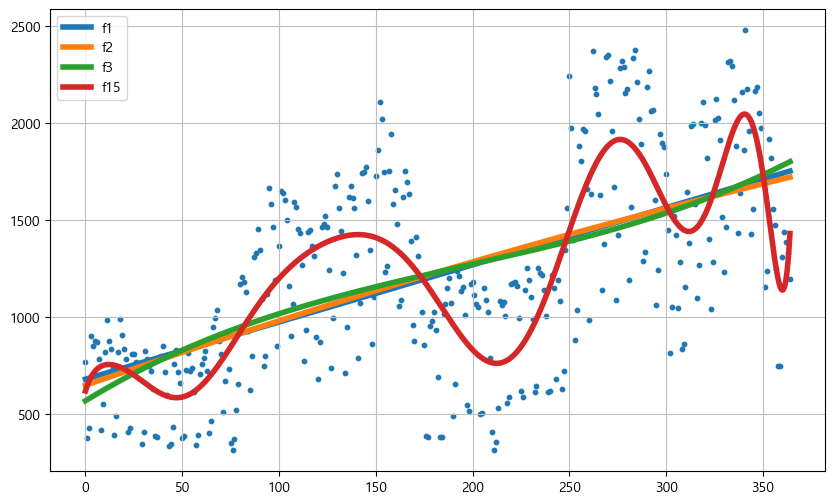

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')  # overfitting

plt.grid(True, linestyle='-', color='0.75')

plt.legend(loc=2)
plt.show()

# 2. Prophet 모듈을 이용한 forecast 예측

In [9]:
df = pd.DataFrame({'ds':pweb.index, 'y':pweb['hit']})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format="%y. %m. %d.")
df.head()

,date,ds,y
0,16. 7. 1.,2016-07-01,766.0
1,16. 7. 2.,2016-07-02,377.0
2,16. 7. 3.,2016-07-03,427.0
3,16. 7. 4.,2016-07-04,902.0
4,16. 7. 5.,2016-07-05,850.0


In [10]:
del df['date'] # df 변수를 생성했으므로 삭제

# Prophet() 함수를 사용 시
# 주기성이 연단위(yearly_seasonality) 및 일단위(daily_seasonality=True)로 있다고 알려줌
# Prophet 클래스 객체를 만들고 시계열 데이터를 입력으로 fit 메서드를 호출

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(df)

16:45:53 - cmdstanpy - INFO - Chain [1] start processing
16:45:53 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# make_future_dataframe : 예측 날짜 구간 생성()
# 16. 7. 1. ~ 17. 6. 30. 홈페이지 방문자 수
future = m.make_future_dataframe(periods=60)
future.head()

,ds
0,2016-07-01
1,2016-07-02
2,2016-07-03
3,2016-07-04
4,2016-07-05


* predict: 신뢰구간을 포함한 예측 실행

In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,901.398379,703.775237,1110.598991
421,2017-08-26,486.266408,260.578665,691.996784
422,2017-08-27,618.928059,414.174886,825.380619
423,2017-08-28,1171.734066,963.785863,1375.587713
424,2017-08-29,1207.743873,987.267201,1429.176432


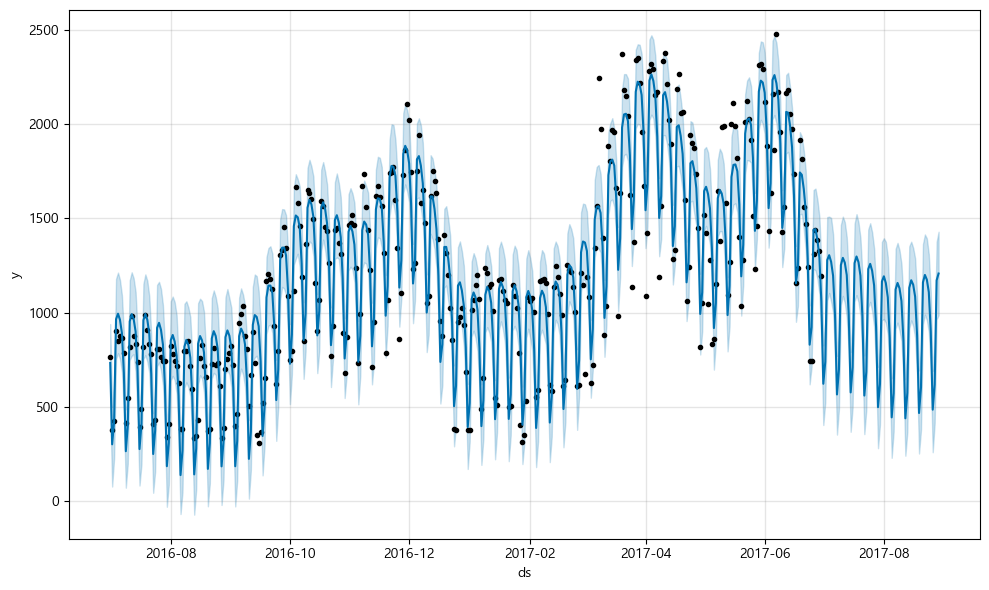

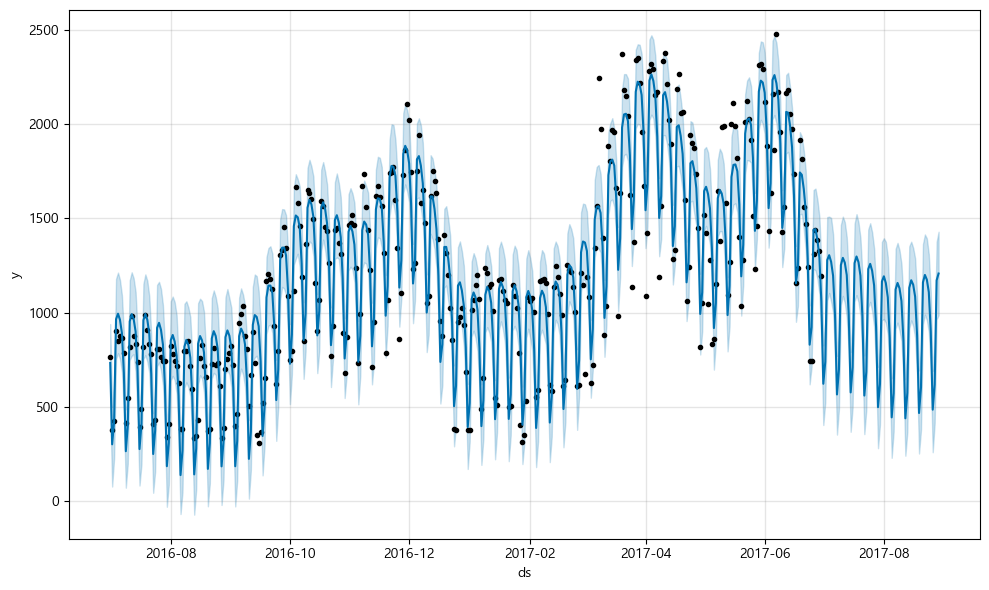

In [13]:
# plot: 원래의 시계열 데이터와 예측 데이터
m.plot(forecast)

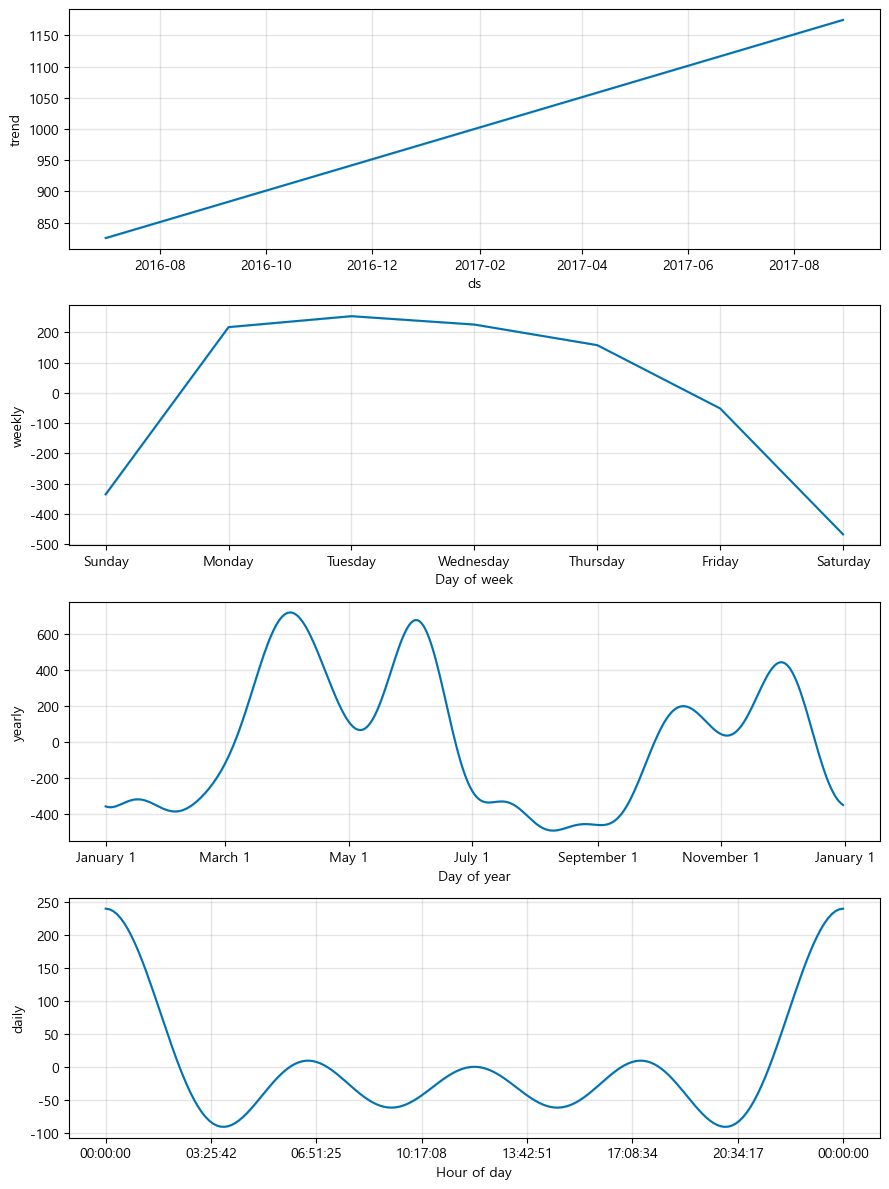

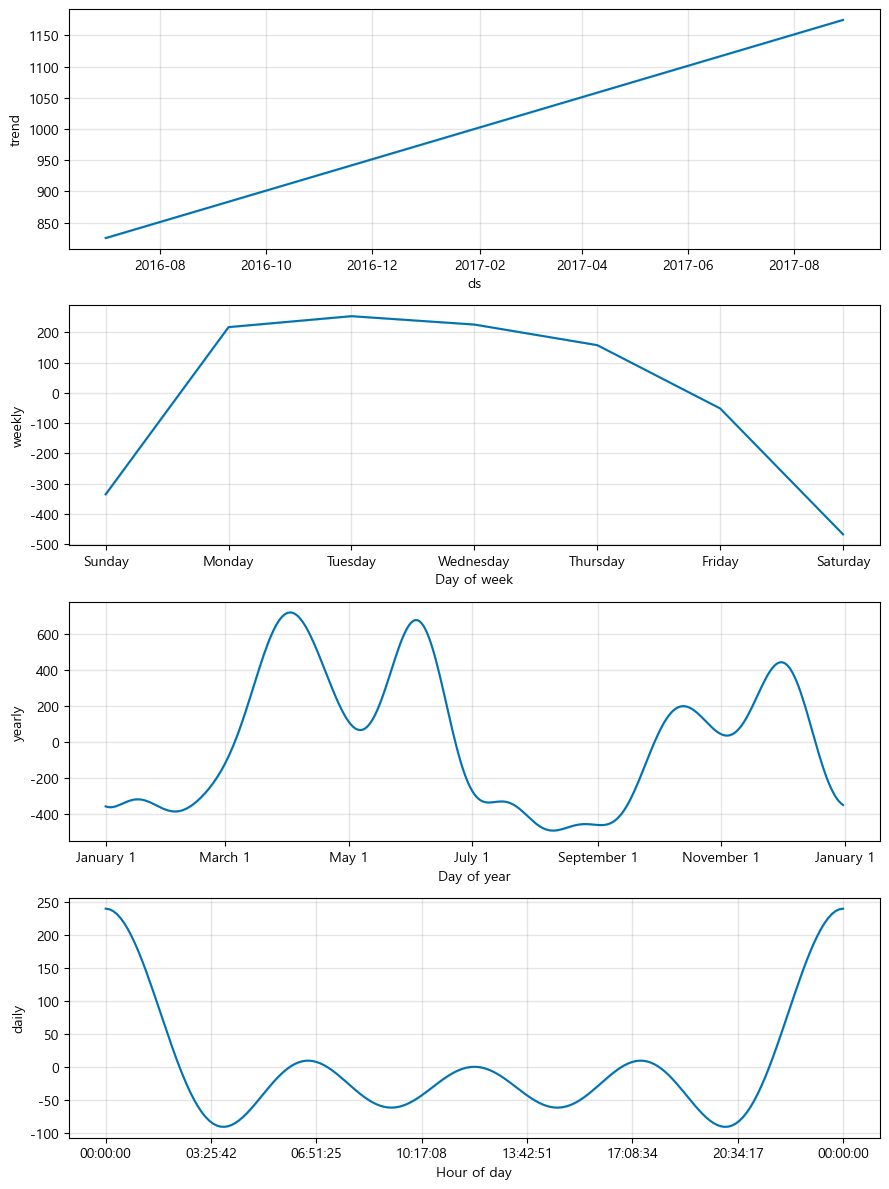

In [14]:
# plot_components: 선형회귀 및 계절성 성분별로 분리
m.plot_components(forecast)

# 3. Seasonal 시계열 분석으로 주식 데이터 분석하기

In [15]:
# https://finance.yahoo.com/
import datetime as dt
import yfinance as yf
company = 'TATAELXSI.NS'

# Define a start date and End Date
start = dt.datetime(2021, 1, 1)
end = dt.datetime(2023, 5, 1)

# Read Stock Price Data
data = yf.download(company, start, end)
data.tail(10)

# oppen 시가, high 고가, low 저가, close 종가, Adj close 조정종가, volume 거래량

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-17,6237.950195,6300.0,6180.000000,6289.750000,6240.825195,108512
2023-04-18,6298.750000,6396.0,6295.000000,6367.299805,6317.771973,100611
2023-04-19,6368.000000,6375.0,6290.049805,6307.200195,6258.139648,69527
2023-04-20,6316.000000,6364.5,6235.350098,6251.649902,6203.021484,90809
2023-04-21,6269.000000,6300.0,6205.549805,6281.000000,6232.143555,66308
2023-04-24,6280.850098,6330.0,6220.049805,6252.950195,6204.312012,61632
2023-04-25,6253.000000,6307.0,6235.299805,6271.200195,6222.419922,47904
2023-04-26,6269.000000,6300.0,6240.000000,6290.850098,6241.916992,56123
2023-04-27,6284.000000,6635.0,6265.149902,6578.200195,6527.031738,493002


In [16]:
start = '2012-7-1'
end = '2022-7-31'
KIA = yf.download('000270.KS', start, end) # 기아차
KIA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-02,75600.0,75900.0,75000.0,75300.0,57019.429688,950363
2012-07-03,75800.0,75800.0,73100.0,73500.0,55656.425781,2542262
2012-07-04,74300.0,74500.0,73600.0,74500.0,56413.644531,1786898
2012-07-05,74600.0,74800.0,73800.0,74100.0,56110.750000,835637
2012-07-06,74400.0,74500.0,73500.0,73700.0,55807.871094,758448


In [17]:
start = '2012-7-1'
end = '2022-7-31'
KAKAO = yf.download('035720.KS', start, end) # 카카오
KAKAO.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-02,20348.544922,20993.250000,20207.515625,20207.515625,19494.722656,396841
2012-07-03,20267.957031,20650.750000,20227.662109,20550.015625,19825.144531,296579
2012-07-04,20670.898438,20751.486328,20288.103516,20408.986328,19689.089844,351768
2012-07-05,20449.279297,20711.191406,20348.544922,20590.308594,19864.013672,239518
2012-07-06,20529.867188,20691.044922,20429.132812,20691.044922,19961.195312,132778


In [18]:
start = '2012-7-1'
end = '2022-7-31'
SAM = yf.download('005930.KS', start, end) # 삼성
SAM.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-02,24160.0,24180.0,23420.0,23480.0,18562.669922,19106750
2012-07-03,23640.0,23860.0,23400.0,23500.0,18578.484375,15801550
2012-07-04,23640.0,23940.0,23560.0,23820.0,18831.460938,19158750
2012-07-05,23740.0,23880.0,23540.0,23700.0,18736.601562,9068550
2012-07-06,23880.0,23880.0,23060.0,23220.0,18357.119141,21158900


<Axes: xlabel='Date'>

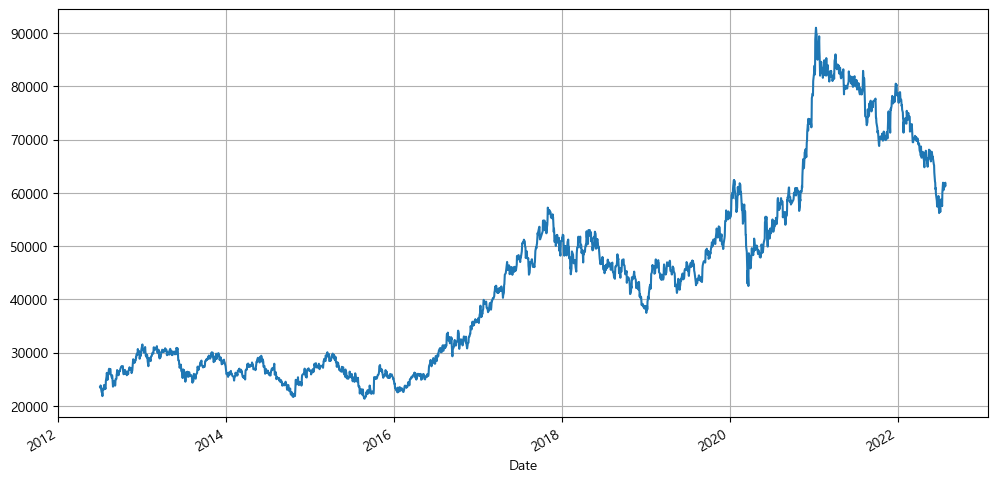

In [19]:
SAM['Close'].plot(figsize=(12,6), grid=True)

In [20]:
SAM_trunc = SAM[:'2022-12-31']
SAM_trunc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-02,24160.0,24180.0,23420.0,23480.0,18562.669922,19106750
2012-07-03,23640.0,23860.0,23400.0,23500.0,18578.484375,15801550
2012-07-04,23640.0,23940.0,23560.0,23820.0,18831.460938,19158750
2012-07-05,23740.0,23880.0,23540.0,23700.0,18736.601562,9068550
2012-07-06,23880.0,23880.0,23060.0,23220.0,18357.119141,21158900
...,...,...,...,...,...,...
2022-07-25,60900.0,61900.0,60800.0,61100.0,59958.777344,9193681
2022-07-26,60800.0,61900.0,60800.0,61700.0,60547.570312,6597211
2022-07-27,61300.0,61900.0,61200.0,61800.0,60645.703125,7320997


In [21]:
df = pd.DataFrame({'ds':SAM_trunc.index, 'y':SAM_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']
df.head()

,ds,y
0,2012-07-02,23480.0
1,2012-07-03,23500.0
2,2012-07-04,23820.0
3,2012-07-05,23700.0
4,2012-07-06,23220.0


In [22]:
# 주기성이 일단위로 있다고 알려줌
m = Prophet(daily_seasonality=True)
m.fit(df)

16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:46:01 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# 위의 df에서 1년치를 예측하겠다
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2839,2023-07-25
2840,2023-07-26
2841,2023-07-27
2842,2023-07-28
2843,2023-07-29


In [24]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2839,2023-07-25,79309.637559,71225.228519,87876.370676
2840,2023-07-26,79304.453351,71186.993432,88040.565048
2841,2023-07-27,79392.731979,71285.285187,87915.863145
2842,2023-07-28,79357.274911,71483.087512,87833.151436
2843,2023-07-29,78919.623670,70468.300319,87604.851549


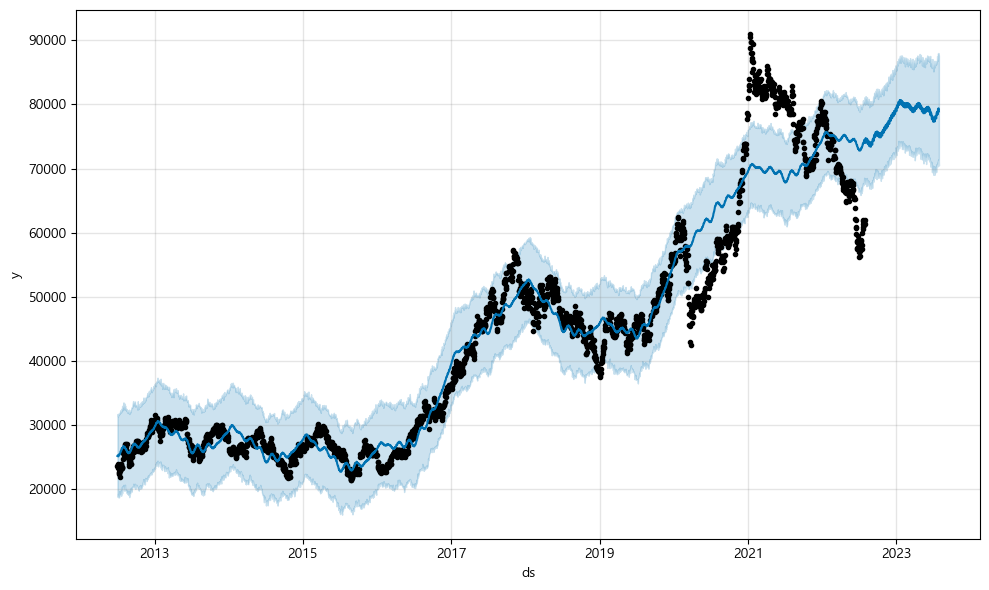

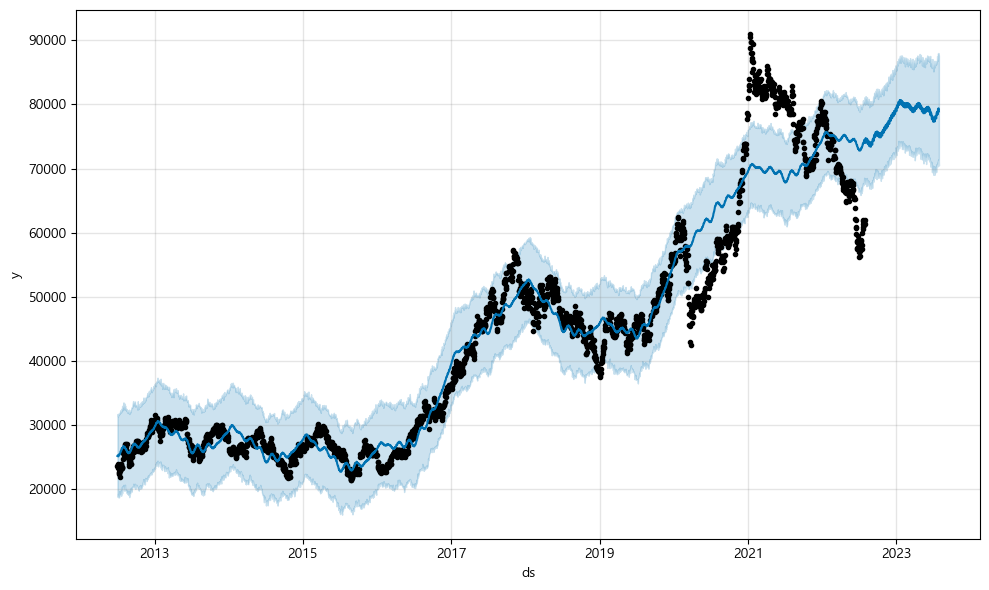

In [25]:
m.plot(forecast)

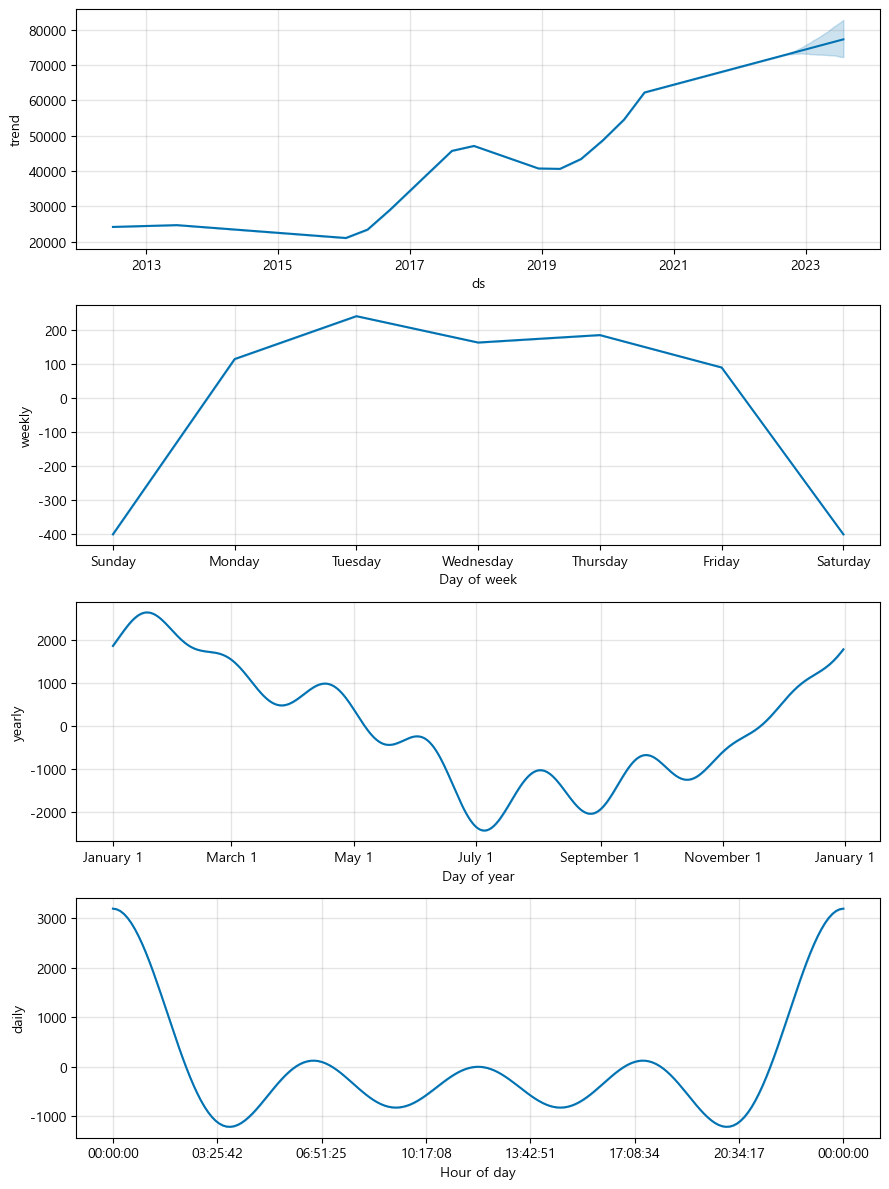

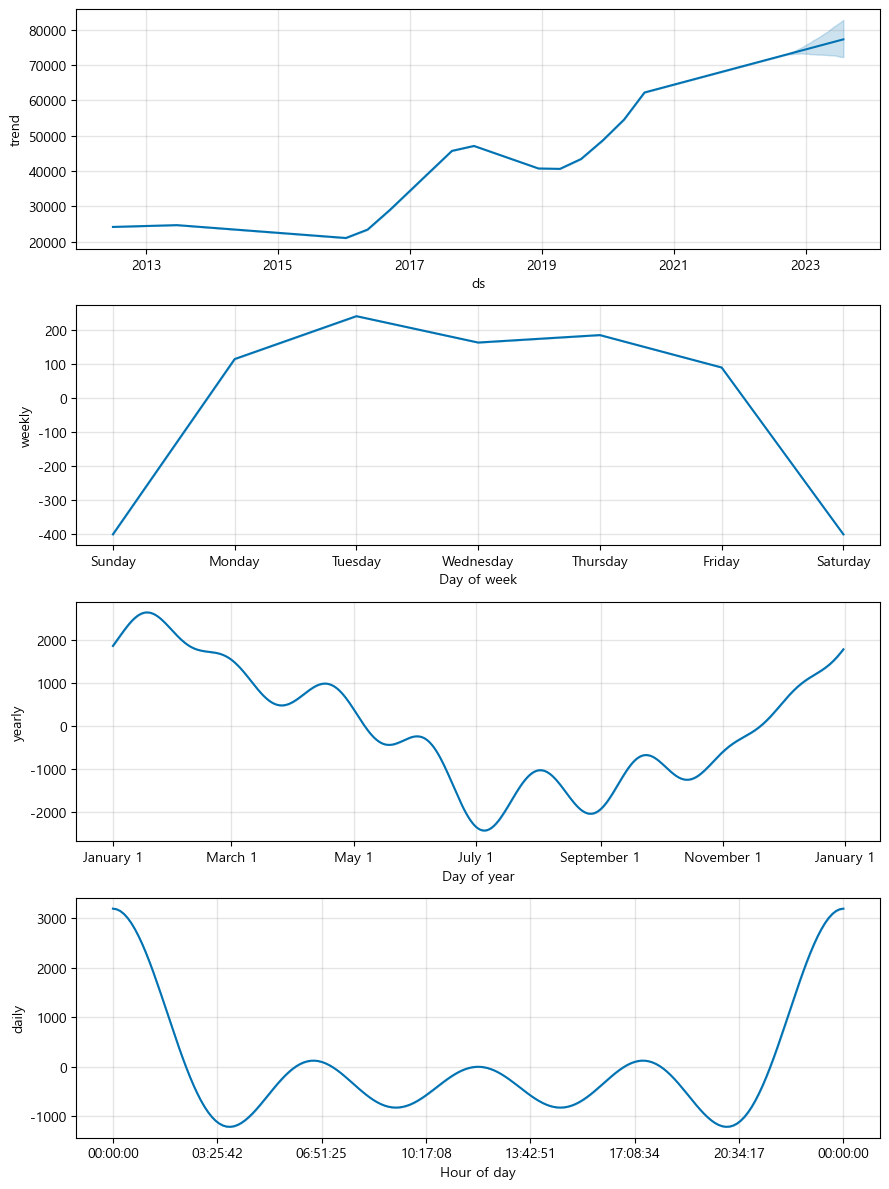

In [26]:
m.plot_components(forecast)

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

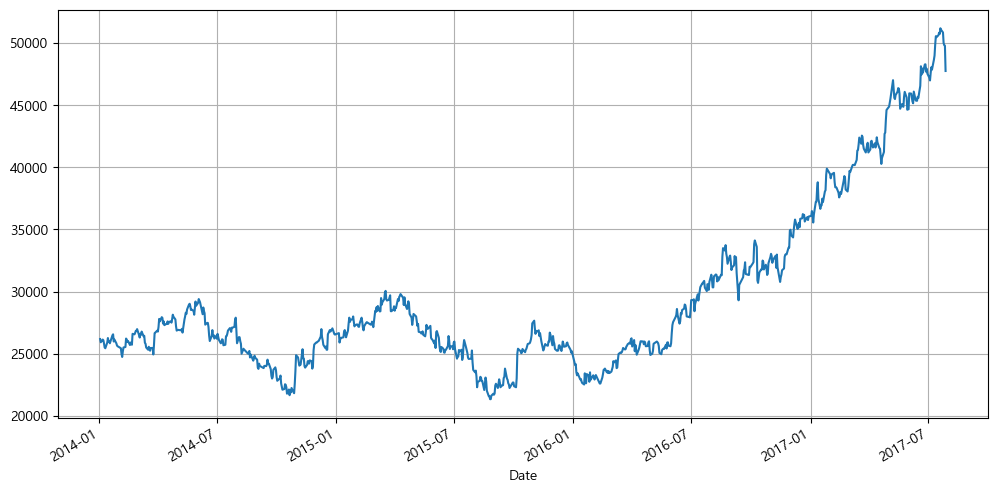

In [27]:
start = '2014-1-1'
end = '2017-7-31'
SAM = yf.download('005930.KS', start, end) # 삼성
SAM['Close'].plot(figsize=(12,6), grid=True)

<Axes: xlabel='Date'>

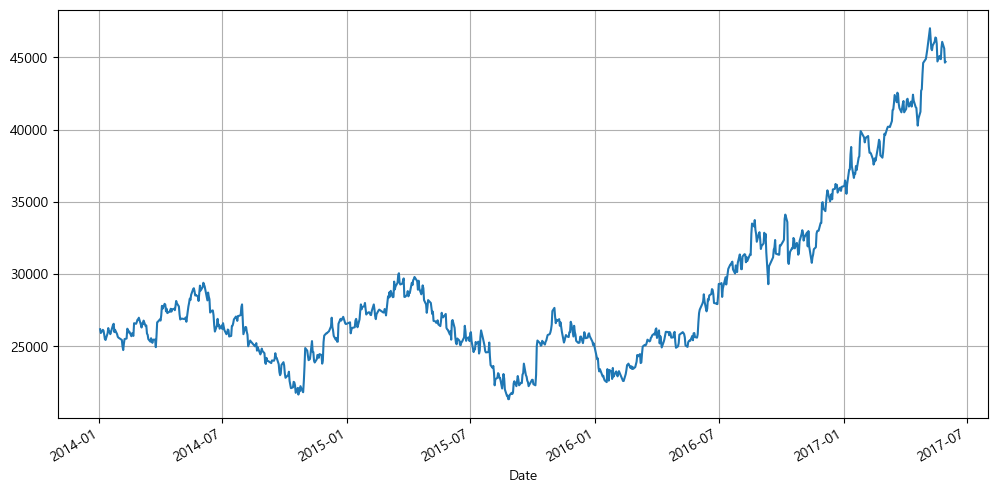

In [28]:
# 일부 데이터를 잘라서 forecast 수행 => 2014-1-1 ~ 2017-7-31
SAM_trunc = SAM[:'2017-05-31']
SAM_trunc['Close'].plot(figsize=(12,6), grid=True)

In [29]:
df = pd.DataFrame({'ds':SAM_trunc.index, 'y':SAM_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']

In [30]:
m = Prophet(daily_seasonality=True)
m.fit(df)

16:46:06 - cmdstanpy - INFO - Chain [1] start processing
16:46:06 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
future = m.make_future_dataframe(periods=61)
future.tail()

,ds
897,2017-07-27
898,2017-07-28
899,2017-07-29
900,2017-07-30
901,2017-07-31


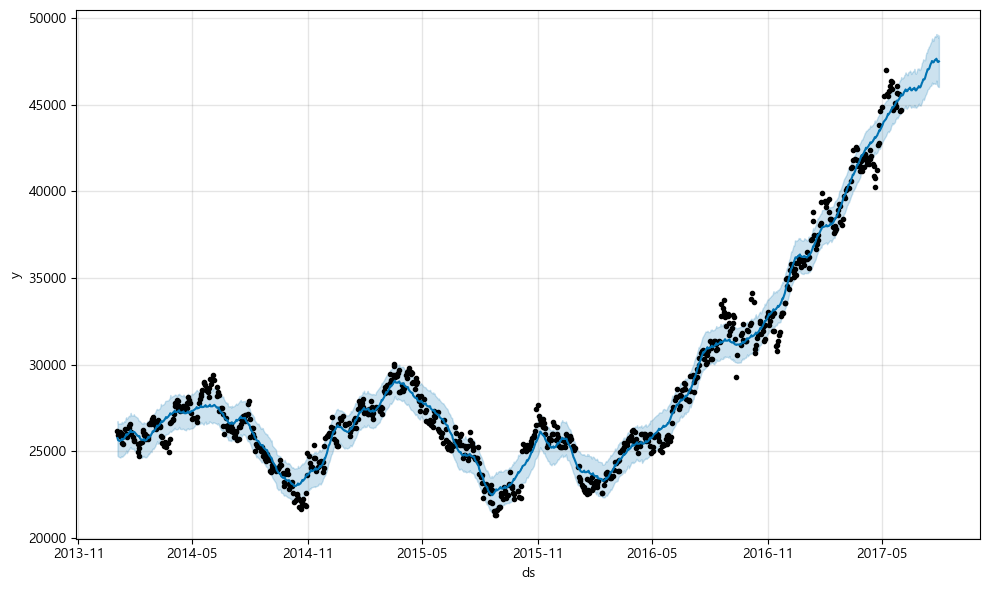

In [32]:
forecast = m.predict(future)
m.plot(forecast);

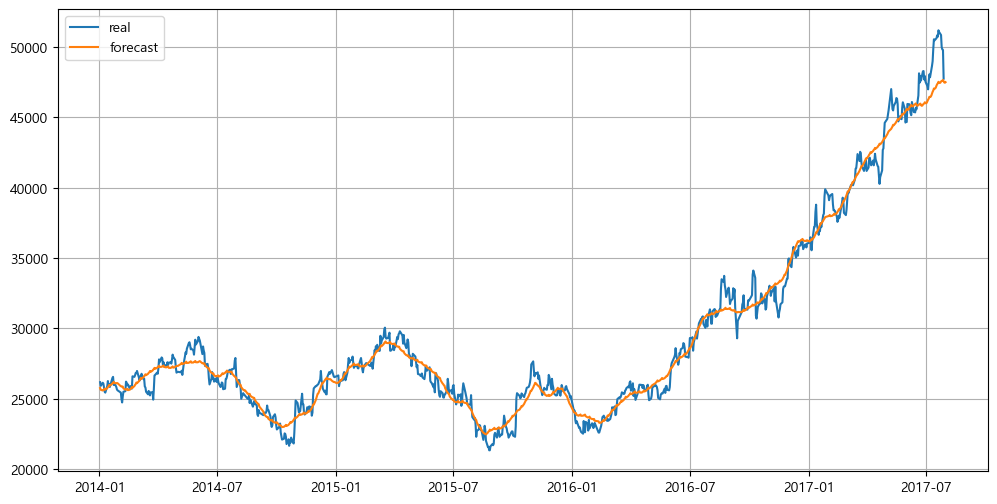

In [33]:
plt.figure(figsize=(12,6))
plt.plot(SAM.index, SAM['Close'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

# 4. Growth Model
 * 주기성을 띠면서 점점 성장하는 모델

In [34]:
df = pd.read_csv('../../data/08. example_wp_R.csv')
df['y'] = np.log(df['y'])   # 로그 변환
df

,ds,y
0,2008-01-30,5.976351
1,2008-01-16,6.049733
2,2008-01-17,6.011267
3,2008-01-14,5.953243
4,2008-01-15,5.910797
...,...,...
2858,2015-12-11,7.834788
2859,2015-12-12,7.360104
2860,2015-12-13,7.479864
2861,2015-12-18,7.765145


In [35]:
# 예측값의 최대 상한, 하한값을 제어할 수 있음
df['cap'] = 8.5  # 예측값의 상한값
df['floor'] = 6  # 예측값의 하한값

In [36]:
# daily_seasonality=True : 주기성이 일단위라고 알려줌
# growth 파라미터를 설정 : 로지스틱 함수
m = Prophet(growth='logistic', daily_seasonality=True)
m.fit(df)

16:46:08 - cmdstanpy - INFO - Chain [1] start processing
16:46:08 - cmdstanpy - INFO - Chain [1] done processing


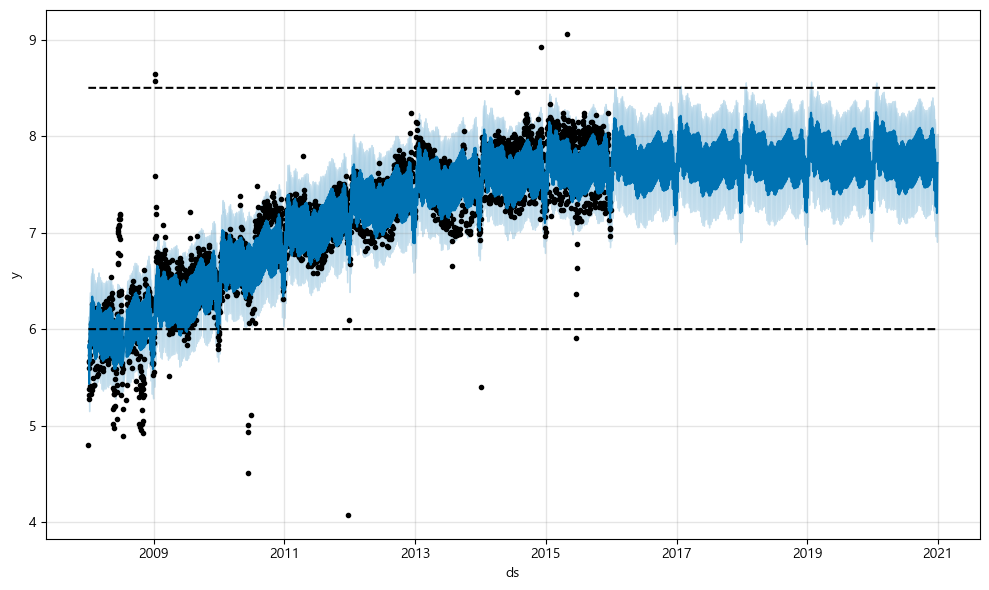

In [37]:
# Prophet은 Linear한 모델을 사용 - 제어하지 않으면 해당 카테고리의
# 최대 사이즈를 넘을 수도 있음(1825일 -> 5년)
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
future['floor'] = 6
fcst = m.predict(future)
m.plot(fcst);

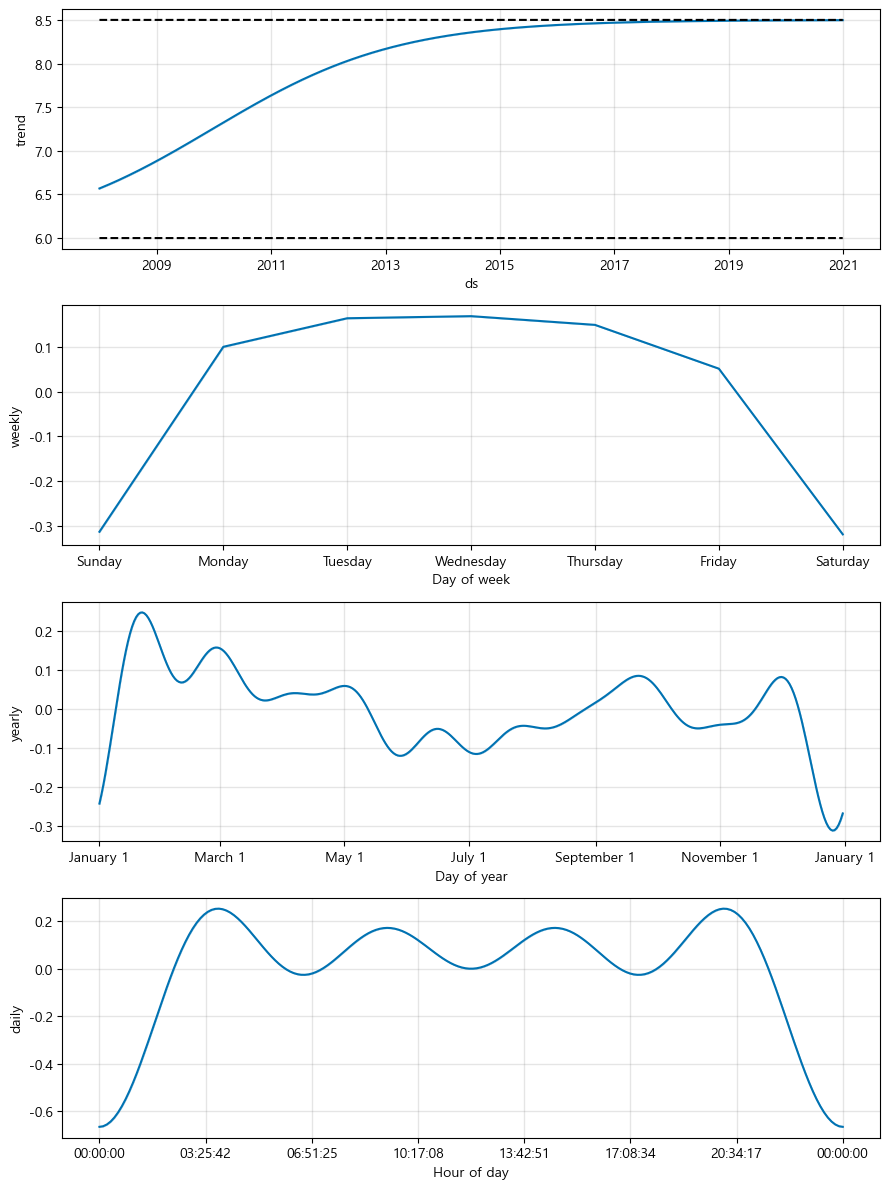

In [38]:
forecast = m.predict(future)
m.plot_components(forecast);

### 1. 관심있는 주식을 분석해 보세요.
### 2. 기간 : 10년치
### 3. 6개월 후 예측해 보세요
#### <한화에어로스페이스 주가예측>

In [39]:
start = '2012-7-1'
end = '2023-7-31'
hanwhaAero = yf.download('012450.KS', start, end) # 한화에어로스페이스
df_han = pd.DataFrame({'ds':hanwhaAero.index, 'y':hanwhaAero['Close']})
df_han.reset_index(inplace=True)
del df_han['Date']

m = Prophet(daily_seasonality=True)
m.fit(df_han)

future = m.make_future_dataframe(periods=181)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

[*********************100%***********************]  1 of 1 completed


16:46:40 - cmdstanpy - INFO - Chain [1] start processing
16:46:41 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
2883,2023-12-28,105717.788834,96303.582508,114361.737294
2884,2023-12-29,105756.688165,97064.901554,114597.808848
2885,2023-12-30,107089.836948,98152.359358,115753.696234
2886,2023-12-31,107187.987911,98441.743063,115587.641210
2887,2024-01-01,106143.506882,97443.648866,115126.941530


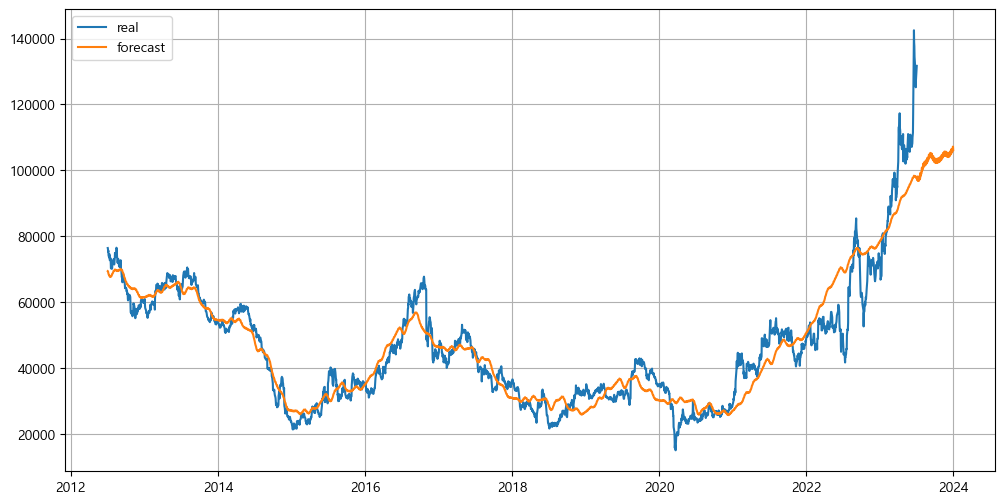

In [40]:
plt.figure(figsize=(12,6))
plt.plot(hanwhaAero.index, hanwhaAero['Close'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

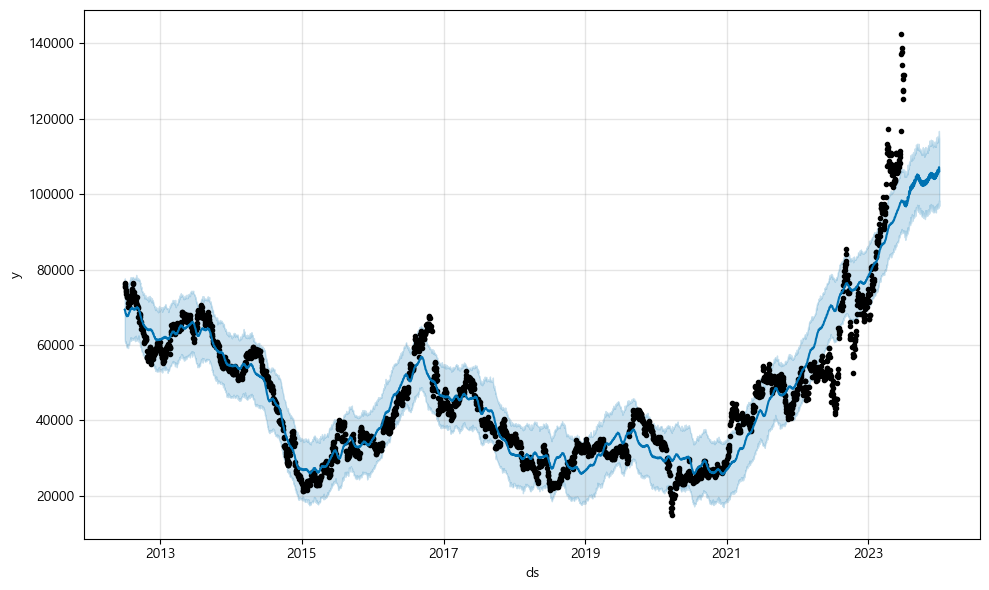

In [41]:
forecast = m.predict(future)
m.plot(forecast);